In [1]:
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path
import os, sys
import numpy as np

from numpy.random import choice
import pandas as pd
from scipy.stats import spearmanr

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(1, os.path.join(sys.path[0], '..'))
sns.set_style('white')
np.random.seed(seed=42)
results_path = Path('results', 'random_forest')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [2]:
class MultipleTimeSeriesCV:
    def __init__(self, n_splits=3, train_period_length=126, test_period_length=21, lookahead=None, date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx, test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[
                (dates[self.date_idx] > days[train_start]) & (dates[self.date_idx] <= days[train_end])].index
            test_idx = dates[(dates[self.date_idx] > days[test_start]) & (dates[self.date_idx] <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [3]:
with pd.HDFStore('data/data.h5') as store:
    data = store['us/equities/monthly']
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 77788 entries, ('A', Timestamp('2006-12-31 00:00:00')) to ('ZION', Timestamp('2017-11-30 00:00:00'))
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   atr            77788 non-null  float64
 1   bb_down        77788 non-null  float64
 2   bb_high        77788 non-null  float64
 3   bb_low         77788 non-null  float64
 4   bb_mid         77788 non-null  float64
 5   bb_up          77788 non-null  float64
 6   macd           77788 non-null  float64
 7   natr           77788 non-null  float64
 8   rsi            77788 non-null  float64
 9   sector         77788 non-null  object 
 10  return_1m      77788 non-null  float64
 11  return_3m      77788 non-null  float64
 12  return_6m      77788 non-null  float64
 13  return_12m     77788 non-null  float64
 14  beta           77788 non-null  float64
 15  SMB            77788 non-null  float64
 16  HML            7778

In [4]:
y = data.target
y_binary = (y > 0).astype(int)
X = pd.get_dummies(data.drop('target', axis=1))
# y_binary

In [5]:
# Cross-validation parameters
n_splits = 10
train_period_length = 60
test_period_length = 6
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits, train_period_length=train_period_length,
                          test_period_length=test_period_length, lookahead=lookahead)

In [6]:
# Classifier
rf_clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
                                max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,
                                oob_score=True, n_jobs=-1, random_state=42, verbose=1)

cv_score = cross_val_score(estimator=rf_clf, X=X, y=y_binary, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.3s finished


In [7]:
np.mean(cv_score)

0.5171907263130099

In [8]:
# Regression RF
def rank_correl(y, y_pred):
    # spearmanr: using ranked value for correlation to understand Nonlinear relationships
    # pearson : using the real value for correlation
    return spearmanr(y, y_pred)[0]

ic = make_scorer(rank_correl)
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,  max_features='auto', max_leaf_nodes=None,
                                min_impurity_decrease=0.0,  bootstrap=True,  oob_score=False, n_jobs=-1,
                                random_state=None, verbose=0,  warm_start=False)

cv_score = cross_val_score(estimator=rf_reg, X=X, y=y, scoring=ic, cv=cv, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.3min finished


In [9]:
np.mean(cv_score)

0.014899954652669727

In [10]:
# Define Parameter Grid
param_grid = {'n_estimators': [50, 100, 250], 'max_depth': [5, 15, None], 'min_samples_leaf': [5, 25, 100]}

# GridSearchCV
gridsearch_clf = GridSearchCV(estimator=rf_clf, param_grid=param_grid, scoring='roc_auc', n_jobs=-1, cv=cv,
                              refit=True, return_train_score=True, verbose=1)

gridsearch_clf.fit(X=X, y=y_binary)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.4s finished


GridSearchCV(cv=<__main__.MultipleTimeSeriesCV object at 0x000001875E667D30>,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [5, 15, None],
                         'min_samples_leaf': [5, 25, 100],
                         'n_estimators': [50, 100, 250]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [11]:
joblib.dump(gridsearch_clf, results_path / 'gridsearch_clf.joblib')
gridsearch_clf = joblib.load(results_path / 'gridsearch_clf.joblib')
gridsearch_clf.best_params_, gridsearch_clf.best_score_

({'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 50},
 0.5209888914455425)

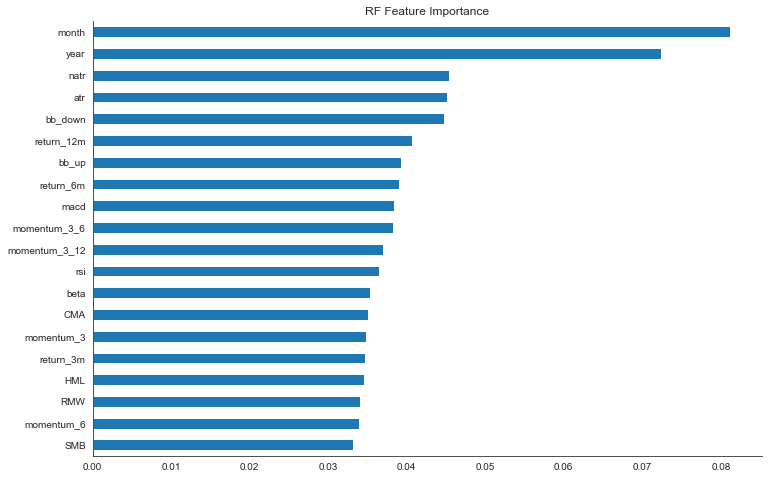

In [18]:
# Feature Importance
fig, ax = plt.subplots(figsize=(12,8))
(pd.Series(gridsearch_clf.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False)
 .iloc[:20].sort_values().plot.barh(ax=ax, title='RF Feature Importance'))
sns.despine()

In [13]:
# Fit Regressor
gridsearch_reg = GridSearchCV(estimator=rf_reg, param_grid=param_grid, scoring=ic, n_jobs=-1, cv=cv,
                      refit=True, return_train_score=True, verbose=1)
gs_reg = gridsearch_reg
gridsearch_reg.fit(X=X, y=y)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


GridSearchCV(cv=<__main__.MultipleTimeSeriesCV object at 0x000001875E667D30>,
             estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [5, 15, None],
                         'min_samples_leaf': [5, 25, 100],
                         'n_estimators': [50, 100, 250]},
             return_train_score=True, scoring=make_scorer(rank_correl),
             verbose=1)

In [14]:
joblib.dump(gridsearch_reg, results_path / 'rf_reg_gridsearch.joblib')
gridsearch_reg = joblib.load(results_path / 'rf_reg_gridsearch.joblib')
gridsearch_reg.best_params_, f'{gridsearch_reg.best_score_*100:.2f}'

({'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}, '4.66')

In [15]:
pd.DataFrame({'Regression': pd.Series(gridsearch_reg.best_params_), 'Classification': pd.Series(gridsearch_clf.best_params_)})

,Regression,Classification
max_depth,5,15
min_samples_leaf,5,5
n_estimators,50,50


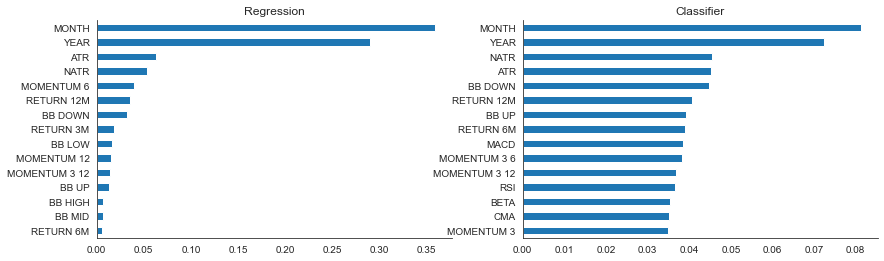

In [16]:
# Feature Importance
fi_clf = gridsearch_clf.best_estimator_.feature_importances_
fi_reg = gridsearch_reg.best_estimator_.feature_importances_
idx = [c.replace('_', ' ').upper() for c in X.columns]
fig, axes = plt.subplots(figsize=(14, 4), ncols=2)
(pd.Series(fi_clf, index=idx).sort_values(ascending=False).iloc[:15].sort_values().plot
 .barh(ax=axes[1], title='Classifier'))
(pd.Series(fi_reg, index=idx).sort_values(ascending=False).iloc[:15].sort_values().plot
 .barh(ax=axes[0], title='Regression'))
sns.despine()